In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we try to solve a made up equation which has following solution:
    \begin{equation}
   \psi =  e^{i(2\pi t/T)}  sin\left(2\pi \vec{k}.\vec{x}\right)
    \end{equation}

    
  We substitute above solution in following equation:
    \begin{equation}
    \partial_t \psi - i\frac{\kappa}{2}(\nabla^2\psi) + iV\psi = 0
    \end{equation}
  
  where
  \begin{equation}
  \nabla^2V = \frac{1}{2\kappa}(|\psi|^2 - 1/2)
  \end{equation}
  
  and we get following modified equation for $\psi(t,\vec{x})$:
    \begin{equation}
    \partial_t \psi - i\frac{\kappa}{2}(\nabla^2\psi) + iV\psi = g(t,\vec{x})
    \end{equation}  
  with 
    \begin{equation}
      g(t,\vec{x}) = i\beta\psi
   \end{equation}
   where
   \begin{equation}
       \beta = \frac{-2\pi}{T} + \frac{\kappa}{2}(\frac{2\pi}{s})^2 |\vec{k}|^2 +V
   \end{equation}
  
    
    
    
    
    

In [2]:
import sys

sys.path.append('../')
from GPE import GPE_scalar_field
from GPE import ImEx


In [3]:
#3-d Fiducial example

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)




def rhs_f(u,xi2,kppa,bta):
    
    u2 = np.square(np.abs(u))
    vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = 0.5*(np.fft.ifftn(vrhsft,vrhsft.shape))/kppa;
    
    
    
    
    
    return (1j*(bta-v)*u)

def im_rhs(psi_ft,xi2,kppa,bta):
   
    psi_ft = -psi_ft*(xi2)
    return(1j*0.5*kppa*np.fft.ifftn(psi_ft,psi_ft.shape))



def calc_max_eig(u,xi2,kppa,bta):
    
    u2 = np.square(np.abs(u))
    
    vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = 0.5*(np.fft.ifftn(vrhsft,vrhsft.shape))/kppa;
    
    rhs = np.max(np.abs(bta-v))
    
    
    
    return (rhs)

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)


def solve_3d_example(m,dt):
    L = 2.0
    
    x = np.arange(-m/2,m/2)*(L/m)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    kppa = 0.0007
    pm = 0.1
    pn = 2.0/L
   
    nx = pn*xv+pn*yv+pn*zv
    k2 = 3.0*(pn**2)
    
    #nx = np.dot(pnv,xv)
    print("nx shape",nx.shape,"x shape",x.shape)
    
    T = 2.0*np.pi/pm
    
    
    u = np.exp(-1j*0.0)*np.sin(2.0*np.pi*nx)
    
    chk_err = sol_err(u,0.0,nx,T,-1.0)
    print("chk err ",chk_err)
   
    print(type(u),u.shape,u.dtype)
    tmax = 2.0

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames = [u.copy()]
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    

    
    
    psi = GPE_scalar_field(3,m,im_rhs,rhs_f,imx,u,relax=True)
    xi2 = (xix*xix+xiy*xiy+xiz*xiz)
    lmbda = (0.5*kppa*xi2)
    
    u2 = np.square(np.abs(u))
    vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    vini = 0.5*(np.fft.ifftn(vrhsft,vrhsft.shape))/kppa;
    
    bta = (-2.0*np.pi/T)+0.5*kppa*2.0*np.pi*2.0*np.pi*k2+vini
    
    print("beta shape",bta.shape)
    
    max_err = -1.0
    
        
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            psi.update_stage_sum(k,dt)
            psi.do_fft(k,lmbda,dt)
            psi.update_K(k,xi2,kppa,bta)
            
        psi.sum_contributions(dt)
        
        
        t = (n+1)*dt
        
#        max_egn = calc_max_eig(u,xi2,kppa,bta)
#        if((max_egn*dt)>imx.r_of_stb.imag):
#            print("maxeg*dt",max_egn*dt,imx.r_of_stb.imag)
#            dt  = 0.9*(imx.r_of_stb.imag/max_egn)
        
        
        
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            tt.append(t)
            max_err = sol_err(psi.psi,t,nx,T,max_err)
            #err_l.append(err)
            
            mass = psi.calc_mass()
            mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            


    max_err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
    mass = psi.calc_mass()
    mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames, x,max_err,mass_l,mass_err_l

In [4]:

dt = 0.001




#frames, x, err_l, mass_l,mass_err_l = solve_3d_example(64,dt)

In [5]:
dtl = [0.001]
err_l = []
mass_err_l=[]
for dt in dtl:
    print(dt)
    frames, x, err, mass,mass_err = solve_3d_example(64,dt)
    err_l.append(err)
    mass_err_l.append(mass_err)

0.001
nx shape (64, 64, 64) x shape (64,)
chk err  0.0
<class 'numpy.ndarray'> (64, 64, 64) complex128
class shapes (64, 64, 64) (3, 64, 64, 64)
(64, 64, 64) (64, 64, 64)
beta shape (64, 64, 64)
Rel gamma is  1.0000000623247092 1.0000000623247092


/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_34334/3183086736.py:108: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_34334/3183086736.py:108: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_34334/3183086736.py:17: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_34334/3183086736.py:17: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2


Rel gamma is  1.0000000394295672 1.0000000394295672
Rel gamma is  1.0000000504721185 1.0000000504721185
Rel gamma is  1.00000004903117 1.00000004903117
Rel gamma is  1.0000000846959822 1.0000000846959822
Rel gamma is  1.0000001158852532 1.0000001158852532
Rel gamma is  1.00000003953564 1.00000003953564
Rel gamma is  1.000000042210399 1.000000042210399
Rel gamma is  1.000000064791737 1.000000064791737
Rel gamma is  1.0000000839197363 1.0000000839197363
Rel gamma is  1.0000000588307445 1.0000000588307445
Rel gamma is  1.0000000773070041 1.0000000773070041
Rel gamma is  1.000000050607431 1.000000050607431
Rel gamma is  1.0000000472052726 1.0000000472052726
Rel gamma is  1.0000000486878184 1.0000000486878184
Rel gamma is  1.0000000309265729 1.0000000309265729
Rel gamma is  1.0000000736275194 1.0000000736275194
Rel gamma is  1.0000000997644996 1.0000000997644996
Rel gamma is  1.000000086024647 1.000000086024647
Rel gamma is  1.000000074182431 1.000000074182431
Rel gamma is  1.00000005038317

Rel gamma is  1.0000000599760805 1.0000000599760805
Rel gamma is  1.0000000750024967 1.0000000750024967
Rel gamma is  1.0000000709280867 1.0000000709280867
Rel gamma is  1.0000000567618292 1.0000000567618292
Rel gamma is  1.0000000415502792 1.0000000415502792
Rel gamma is  1.0000000742284416 1.0000000742284416
Rel gamma is  1.0000001152144888 1.0000001152144888
Rel gamma is  1.0000000605863903 1.0000000605863903
Rel gamma is  1.000000104161205 1.000000104161205
Rel gamma is  1.0000000458636482 1.0000000458636482
Rel gamma is  1.0000000663939614 1.0000000663939614
Rel gamma is  1.0000000831060583 1.0000000831060583
Rel gamma is  1.0000000648079037 1.0000000648079037
Rel gamma is  1.0000000368632118 1.0000000368632118
Rel gamma is  1.000000050340378 1.000000050340378
Rel gamma is  1.0000000657750179 1.0000000657750179
Rel gamma is  1.0000000291034294 1.0000000291034294
Rel gamma is  1.0000000569781673 1.0000000569781673
Rel gamma is  1.0000000558932511 1.0000000558932511
Rel gamma is  1.

Rel gamma is  1.0000001002323649 1.0000001002323649
Rel gamma is  1.0000000486313765 1.0000000486313765
Rel gamma is  1.0000001127694544 1.0000001127694544
Rel gamma is  1.0000000503622346 1.0000000503622346
Rel gamma is  1.0000000811028187 1.0000000811028187
Rel gamma is  1.0000000421802302 1.0000000421802302
Rel gamma is  1.0000000595289196 1.0000000595289196
Rel gamma is  1.0000000731251775 1.0000000731251775
Rel gamma is  1.000000067974628 1.000000067974628
Rel gamma is  1.0000000762136185 1.0000000762136185
Rel gamma is  1.000000052386771 1.000000052386771
Rel gamma is  1.0000000739621595 1.0000000739621595
Rel gamma is  1.0000000648838057 1.0000000648838057
Rel gamma is  1.0000000601470995 1.0000000601470995
Rel gamma is  1.0000000740956516 1.0000000740956516
Rel gamma is  1.0000000714806172 1.0000000714806172
Rel gamma is  1.0000000111624892 1.0000000111624892
Rel gamma is  1.0000000992145255 1.0000000992145255
Rel gamma is  1.0000000600675036 1.0000000600675036
Rel gamma is  1.

Rel gamma is  1.0000000589224818 1.0000000589224818
Rel gamma is  1.0000000938879414 1.0000000938879414
Rel gamma is  1.0000000531470796 1.0000000531470796
Rel gamma is  1.0000000520546068 1.0000000520546068
Rel gamma is  1.0000000806019764 1.0000000806019764
Rel gamma is  1.0000000455189029 1.0000000455189029
Rel gamma is  1.0000000652284393 1.0000000652284393
Rel gamma is  1.0000000580395068 1.0000000580395068
Rel gamma is  1.0000000344286601 1.0000000344286601
Rel gamma is  1.000000057731593 1.000000057731593
Rel gamma is  1.000000030527423 1.000000030527423
Rel gamma is  1.0000000913301947 1.0000000913301947
Rel gamma is  1.000000071801823 1.000000071801823
Rel gamma is  1.0000000523490968 1.0000000523490968
Rel gamma is  1.0000000680039332 1.0000000680039332
Rel gamma is  1.0000000573521495 1.0000000573521495
Rel gamma is  1.000000059550034 1.000000059550034
Rel gamma is  1.0000000638837039 1.0000000638837039
Rel gamma is  1.0000000691007056 1.0000000691007056
Rel gamma is  1.0000

Rel gamma is  1.0000000529784956 1.0000000529784956
Rel gamma is  1.000000058549493 1.000000058549493
Rel gamma is  1.0000000752079212 1.0000000752079212
Rel gamma is  1.0000000748852789 1.0000000748852789
Rel gamma is  1.0000000789131611 1.0000000789131611
Rel gamma is  1.000000032913077 1.000000032913077
Rel gamma is  1.0000000539331986 1.0000000539331986
Rel gamma is  1.0000000534089721 1.0000000534089721
Rel gamma is  1.000000096838836 1.000000096838836
Rel gamma is  1.0000000755738707 1.0000000755738707
Rel gamma is  1.0000001172966644 1.0000001172966644
Rel gamma is  1.0000001131544078 1.0000001131544078
Rel gamma is  1.0000000656562196 1.0000000656562196
Rel gamma is  1.0000000868367294 1.0000000868367294
Rel gamma is  1.000000090321227 1.000000090321227
Rel gamma is  1.0000000341831956 1.0000000341831956
Rel gamma is  1.000000085618154 1.000000085618154
Rel gamma is  1.000000068832584 1.000000068832584
Rel gamma is  1.0000000300839795 1.0000000300839795
Rel gamma is  1.00000006

Rel gamma is  1.0000000845159778 1.0000000845159778
Rel gamma is  1.0000000655670183 1.0000000655670183
Rel gamma is  1.0000000794366926 1.0000000794366926
Rel gamma is  1.000000043007837 1.000000043007837
Rel gamma is  1.0000000782662712 1.0000000782662712
Rel gamma is  1.0000000441093322 1.0000000441093322
Rel gamma is  1.0000000572412358 1.0000000572412358
Rel gamma is  1.000000039626453 1.000000039626453
Rel gamma is  1.0000000612617148 1.0000000612617148
Rel gamma is  1.0000000840903842 1.0000000840903842
Rel gamma is  1.000000097916734 1.000000097916734
Rel gamma is  1.000000079506706 1.000000079506706
Rel gamma is  1.000000051685696 1.000000051685696
Rel gamma is  1.0000000979926953 1.0000000979926953
Rel gamma is  1.000000048792342 1.000000048792342
Rel gamma is  1.0000000235755453 1.0000000235755453
Rel gamma is  1.0000000418396782 1.0000000418396782
Rel gamma is  1.0000000198130894 1.0000000198130894
Rel gamma is  1.0000000376284988 1.0000000376284988
Rel gamma is  1.00000008

Rel gamma is  1.000000077176875 1.000000077176875
Rel gamma is  1.0000000735309018 1.0000000735309018
Rel gamma is  1.0000000613796929 1.0000000613796929
Rel gamma is  1.000000057984705 1.000000057984705
Rel gamma is  1.0000000579880663 1.0000000579880663
Rel gamma is  1.0000000550918668 1.0000000550918668
Rel gamma is  1.0000000454687454 1.0000000454687454
Rel gamma is  1.000000054522557 1.000000054522557
Rel gamma is  1.0000000474721205 1.0000000474721205
Rel gamma is  1.000000052386394 1.000000052386394
Rel gamma is  1.0000000654783796 1.0000000654783796
Rel gamma is  1.0000000779138274 1.0000000779138274
Rel gamma is  1.0000000530049444 1.0000000530049444
Rel gamma is  1.0000000551455923 1.0000000551455923
Rel gamma is  1.0000000686572146 1.0000000686572146
Rel gamma is  1.0000000521603358 1.0000000521603358
Rel gamma is  1.0000001058031514 1.0000001058031514
Rel gamma is  1.000000055340608 1.000000055340608
Rel gamma is  1.0000000675409269 1.0000000675409269
Rel gamma is  1.000000

Rel gamma is  1.0000000945409908 1.0000000945409908
Rel gamma is  1.000000078408606 1.000000078408606
Rel gamma is  1.0000000548833923 1.0000000548833923
Rel gamma is  1.00000006127148 1.00000006127148
Rel gamma is  1.0000000170901222 1.0000000170901222
Rel gamma is  1.0000000785851604 1.0000000785851604
Rel gamma is  1.0000000460243839 1.0000000460243839
Rel gamma is  1.0000001075874603 1.0000001075874603
Rel gamma is  1.0000000688247368 1.0000000688247368
Rel gamma is  1.0000000602868266 1.0000000602868266
Rel gamma is  1.0000000211212834 1.0000000211212834
Rel gamma is  1.0000000601780985 1.0000000601780985
Rel gamma is  1.0000000303061947 1.0000000303061947
Rel gamma is  1.0000000525095631 1.0000000525095631
Rel gamma is  1.0000000820912471 1.0000000820912471
Rel gamma is  1.00000005429898 1.00000005429898
Rel gamma is  1.0000000606730617 1.0000000606730617
Rel gamma is  1.0000000295112408 1.0000000295112408
Rel gamma is  1.0000000984136304 1.0000000984136304
Rel gamma is  1.000000

Rel gamma is  1.0000000535665912 1.0000000535665912
Rel gamma is  1.0000000772292963 1.0000000772292963
Rel gamma is  1.000000055102231 1.000000055102231
Rel gamma is  1.000000051068666 1.000000051068666
Rel gamma is  1.0000000693151083 1.0000000693151083
Rel gamma is  1.0000000774176874 1.0000000774176874
Rel gamma is  1.0000000658229151 1.0000000658229151
Rel gamma is  1.0000000534674514 1.0000000534674514
Rel gamma is  1.0000000619372134 1.0000000619372134
Rel gamma is  1.0000000837539254 1.0000000837539254
Rel gamma is  1.00000002302059 1.00000002302059
Rel gamma is  1.0000000636826472 1.0000000636826472
Rel gamma is  1.0000000674799492 1.0000000674799492
Rel gamma is  1.0000000445022648 1.0000000445022648
Rel gamma is  1.0000000287709758 1.0000000287709758
Rel gamma is  1.0000000349624905 1.0000000349624905
Rel gamma is  1.000000080947551 1.000000080947551
Rel gamma is  1.000000039270195 1.000000039270195
Rel gamma is  1.0000001084600247 1.0000001084600247
Rel gamma is  1.00000006

Rel gamma is  1.0000000703646292 1.0000000703646292
Rel gamma is  1.0000000939890612 1.0000000939890612
Rel gamma is  1.000000039154479 1.000000039154479
Rel gamma is  1.0000000618997873 1.0000000618997873
Rel gamma is  1.0000000832319726 1.0000000832319726
Rel gamma is  1.0000000713948158 1.0000000713948158
Rel gamma is  1.0000000612666573 1.0000000612666573
Rel gamma is  1.0000000671069829 1.0000000671069829
Rel gamma is  1.000000054630347 1.000000054630347
Rel gamma is  1.000000042301244 1.000000042301244
Rel gamma is  1.0000000501944815 1.0000000501944815
Rel gamma is  1.0000000647160412 1.0000000647160412
Rel gamma is  1.0000000843033159 1.0000000843033159
Rel gamma is  1.0000000578715733 1.0000000578715733
Rel gamma is  1.0000000685046162 1.0000000685046162
Rel gamma is  1.000000037469444 1.000000037469444
Rel gamma is  1.0000000607041184 1.0000000607041184
Rel gamma is  1.0000000467870385 1.0000000467870385
Rel gamma is  1.0000000749314455 1.0000000749314455
Rel gamma is  1.0000

Rel gamma is  1.0000000983304107 1.0000000983304107
Rel gamma is  1.0000000757584522 1.0000000757584522
Rel gamma is  1.0000000689698236 1.0000000689698236
Rel gamma is  1.0000000824813267 1.0000000824813267
Rel gamma is  1.0000000659229011 1.0000000659229011
Rel gamma is  1.0000000676138558 1.0000000676138558
Rel gamma is  1.000000056319685 1.000000056319685
Rel gamma is  1.0000000528999053 1.0000000528999053
Rel gamma is  1.0000000348218148 1.0000000348218148
Rel gamma is  1.0000000597957859 1.0000000597957859
Rel gamma is  1.0000000607380328 1.0000000607380328
Rel gamma is  1.000000036380627 1.000000036380627
Rel gamma is  1.0000000560978997 1.0000000560978997
Rel gamma is  1.0000000741973165 1.0000000741973165
Rel gamma is  1.0000000123113901 1.0000000123113901
Rel gamma is  1.0000000473890547 1.0000000473890547
Rel gamma is  1.000000033855536 1.000000033855536
Rel gamma is  1.0000000755138476 1.0000000755138476
Rel gamma is  1.0000000406593876 1.0000000406593876
Rel gamma is  1.00

Rel gamma is  1.0000000424586546 1.0000000424586546
Rel gamma is  1.0000000795301072 1.0000000795301072
Rel gamma is  1.0000000984194624 1.0000000984194624
Rel gamma is  1.0000000318621687 1.0000000318621687
Rel gamma is  1.0000000971429517 1.0000000971429517
Rel gamma is  1.0000001079313663 1.0000001079313663
Rel gamma is  1.0000000733451693 1.0000000733451693
Rel gamma is  1.0000001040477318 1.0000001040477318
Rel gamma is  1.0000000657706736 1.0000000657706736
Rel gamma is  1.0000000919116863 1.0000000919116863
Rel gamma is  1.0000000439785206 1.0000000439785206
Rel gamma is  1.0000000780932552 1.0000000780932552
Rel gamma is  1.00000005099787 1.00000005099787
Rel gamma is  1.0000000597257237 1.0000000597257237
Rel gamma is  1.0000000756703802 1.0000000756703802
Rel gamma is  1.0000000765954729 1.0000000765954729
Rel gamma is  1.0000000481835527 1.0000000481835527
Rel gamma is  1.0000000534425135 1.0000000534425135
Rel gamma is  1.0000000303000793 1.0000000303000793
Rel gamma is  1.

Rel gamma is  1.000000092278572 1.000000092278572
Rel gamma is  1.0000000368244104 1.0000000368244104
Rel gamma is  1.0000000907150932 1.0000000907150932
Rel gamma is  1.0000000442620078 1.0000000442620078
Rel gamma is  1.0000000681366084 1.0000000681366084
Rel gamma is  1.0000000850528414 1.0000000850528414
Rel gamma is  1.0000000695815747 1.0000000695815747
Rel gamma is  1.0000000789971137 1.0000000789971137
Rel gamma is  1.0000000691065367 1.0000000691065367
Rel gamma is  1.0000000701423735 1.0000000701423735
Rel gamma is  1.0000000380637137 1.0000000380637137
Rel gamma is  1.0000000737365524 1.0000000737365524
Rel gamma is  1.0000000715141544 1.0000000715141544
Rel gamma is  1.0000000648544938 1.0000000648544938
Rel gamma is  1.000000083868562 1.000000083868562
Rel gamma is  1.0000000748006295 1.0000000748006295
Rel gamma is  1.0000000802396865 1.0000000802396865
Rel gamma is  1.0000000511721197 1.0000000511721197
Rel gamma is  1.0000000471045436 1.0000000471045436
Rel gamma is  1.

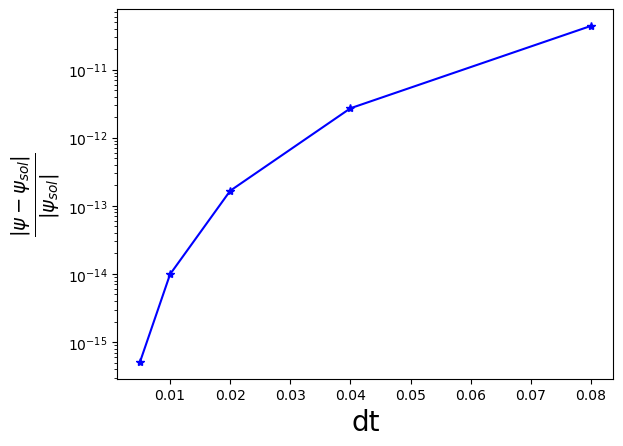

In [22]:
#err_l_max = [np.max(np.abs(np.array(er))) for er in err_l]
fig = plt.figure()
plt.yscale('log')
plt.xlabel("dt",fontsize=20)
plt.ylabel(r"$\frac{|\psi-\psi_{sol}|}{|\psi_{sol}|} $",fontsize=20)
plt.plot(dtl,err_l,"b-*")

plt.savefig("fiducial.pdf")

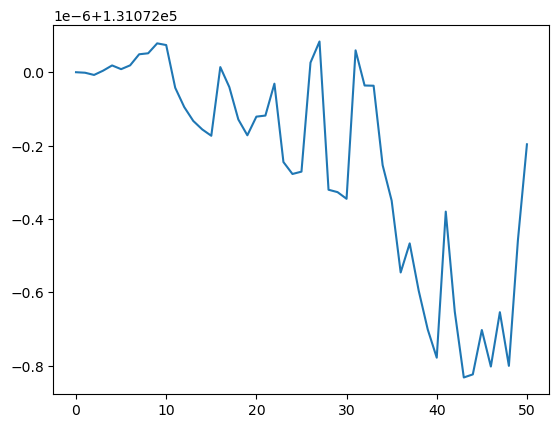

In [48]:
plt.plot(mass_l)